# EELS quantification in pyEELSMODEL with Dirac GOS

Author: Zezhong Zhang 

Affiliation: University of Antwerp & University of Oxford

Email: zehong.zhang@uantwerpen.be

## How to do EELS quantification
Step 0, we will first download database and visualize the GOS, check the spin-orbit splitting which yields from the Dirac equation. 

Step 1, we need to compute the DDSCS from the GOS database for the non-relativistic scattering but with atomic orbitals obtained from the Dirac equation. Then we need to account for the relativistic nature of the fast incoming electron.

Step 2, we need to integrate the DDSCS within the EELS collection aperture to obtain the differential cross-sections for parallel illumination. If convergent beam illumination is used in STEM-EELS, we have to correct it with a geometric cross-correlation function. The momentum space integration for both parallel and convergent beam illumination is implemented in pyEELSModel.

Step 3, the computed differential cross-sections for all edges are fitted together to the experimental spectrum for quantification. During the model-based fitting process, the core-loss spectrum can be convoluted with the low-loss spectrum to consider the source energy dispersion and plural plasmon scattering. The fitting procedure can be performed using the existing packages such as EELSModel, HyperSpy, or Gatan Digital Micrograph, which now all support the Dirac-based GOS. In this tutorial, we will demostrate with pyEELSModel with two quantification methods:
1. Conventional power-law: Estimation of the background by fitting a power-law to the pre edge region.
2. Model-based approach: Define a model with fine structure, all the steps are shown on how to get the results
   
The quantification part is adapted from [pyEELSMODEL notebooks](https://github.com/joverbee/pyEELSMODEL/blob/main/examples), for more advanced model fitting with fine structures, please check this [notebook](https://github.com/joverbee/pyEELSMODEL/blob/main/examples/FineStructureOnSrTiO3.ipynb) by Daen Jannis. 

# Step 0: Download the GOS and install pyEELSMODEL

In [28]:
# download the database
import requests
import os

def download_file(url, filename):
    # Send a GET request to the URL
    response = requests.get(url, stream=True)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open a local file with write-binary mode
        with open(filename, 'wb') as f:
            # Write the content to the file in chunks
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded '{filename}' successfully.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# Example usage
url = 'https://zenodo.org/records/11199911/files/Dirac_GOS.gosh'  # Replace this with the actual URL
filename = 'data/Dirac_GOS.gosh'  # Replace this with the desired local filename

if os.path.exists(filename) == False:
    download_file(url, filename)


In [ ]:
# install pyEELSMODEL
# !pip install pyEELSMODEL

# before the PR #25 is merged, we need to install the package from the forked repository
!git clone https://github.com/zezhong-zhang/pyEELSMODEL.git
!cd pyEELSMODEL
!git checkout dev
!pip install .

# Step 0: Visualize the GOS

The name "generalized oscillator strength" comes from the extension of the "oscillator strength", which describes the probability of absorption or emission of electromagnetic radiation caused by the electron orbital transitions for an atom or molecule. Indeed the precise analysis of atomic light spectra, tracing back to the starting point of quantum mechanics, lays the foundation of atomic physics. For EELS, GOS describes the probability of inelastic electron scattering defined as: 

$f(q,E) = \frac{\Delta E}{R} \frac{\left|S(q,E)\right|^2}{(qa_0)^2}$,

where f(q,E) is GOS, defined in such manner to be independent of the incident beam energy. $\Delta E$ is the energy loss, $R$ is the Rydberg energy, $q$ is the scattering vector (or equivalently momemntum transfer), $a_0$ is the Bohr radius. $S(q,E)$ is the transition matrix element calculated from the Fermi's golden rule, which states that the transition probability is proportional to the strength of the coupling between the initial and final states under weak perturbation (first Born approximation). 

Here we first have a look of how GOS looks like. The GOS database is tabulated as a function of energy loss and momentum transfer. The fine sampling  enables the clear visualization of the Bethe ridge with locally high transition probabilities in a parabolic region ($\Delta E \sim q^2$) in the energy-momentum space.

Downloaded 'data/Dirac_GOS.gosh' successfully.


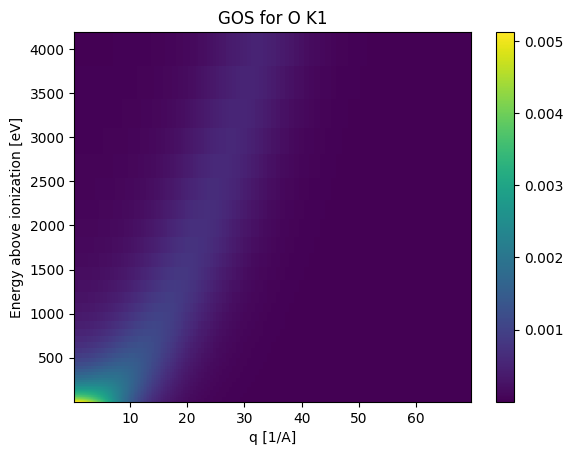

In [1]:
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edge import ZezhongCoreLossEdge
from pyEELSMODEL.core.spectrum import Spectrumshape
import matplotlib.pyplot as plt

specshape = Spectrumshape(dispersion=0.1,offset=280,size=3000)
A = 1
E0=300e3
alpha = 0
beta = 0.1
element = 'O'
edge = 'K' 
q_steps=100

edge = ZezhongCoreLossEdge(specshape=specshape, A=A, E0=E0, alpha=alpha, beta=beta, element=element, edge=edge, q_steps=q_steps,dir_path='data/')

def plot_gos(edge):
    plt.figure()
    plt.pcolormesh( edge.q_axis/1e10,edge.free_energies, edge.gos)
    plt.xlabel('q [1/A]')
    plt.ylabel('Energy above ionization [eV]')
    plt.colorbar()
    plt.title('GOS for ' + edge.element + ' ' + edge.edge)
    plt.show()

plot_gos(edge)

# Step 0: the spin-orbit splitting 
The key benefit of employing the Dirac equation lies in its intrinsic inclusion of relativistic effects, rather than applying corrections to the Schrödinger equation. In the context of EELS, a notable advantage is the precise prediction of spin-orbit splittings of different elements. For instance, for spin-up and down we would expect diffferent onset energy and different gos


In [2]:
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edge import ZezhongCoreLossEdge
from pyEELSMODEL.core.spectrum import Spectrumshape

specshape = Spectrumshape(dispersion=0.1,offset=280,size=3000)
A = 1
E0=300e3
alpha = 0
beta = 0.1
element = 'Ti'
q_steps=100

Ti_L2 = ZezhongCoreLossEdge(specshape=specshape, A=A, E0=E0, alpha=alpha, beta=beta, element=element, edge='L2', q_steps=q_steps,dir_path='data/')
Ti_L3 = ZezhongCoreLossEdge(specshape=specshape, A=A, E0=E0, alpha=alpha, beta=beta, element=element, edge='L3', q_steps=q_steps,dir_path='data/')

print(f'Ti L2 Dirac ionization energy: {Ti_L2.ionization_energy} eV')
print(f'Ti L3 Dirac ionization energy: {Ti_L3.ionization_energy} eV')

print(f'Ti L2 EELS atlas onset energy: {Ti_L2.onset_energy} eV')
print(f'Ti L3 EELS atlas onset energy: {Ti_L3.onset_energy} eV')


Ti L2 Dirac ionization energy: 453.521969 eV
Ti L3 Dirac ionization energy: 447.697111 eV
Ti L2 EELS atlas onset energy: 462 eV
Ti L3 EELS atlas onset energy: 456 eV


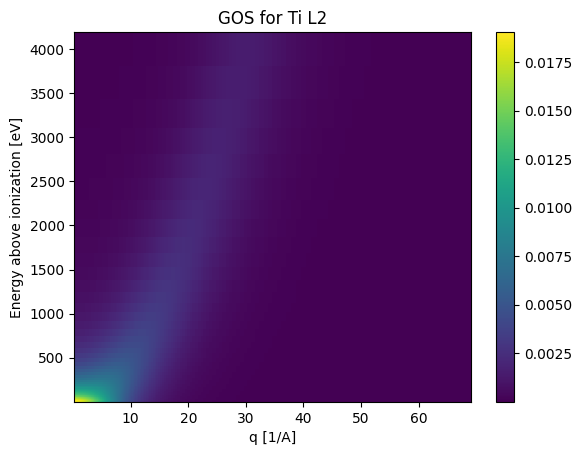

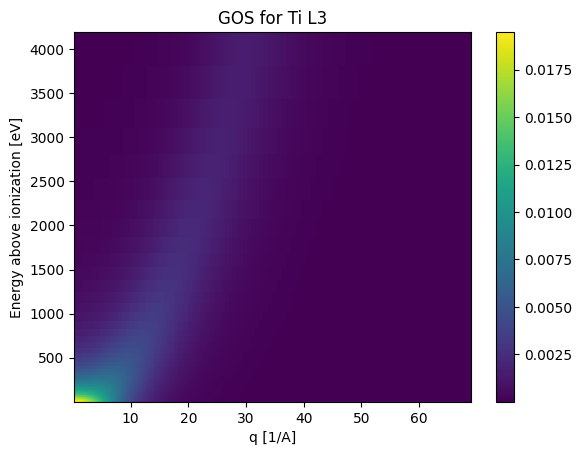

Text(0.5, 1.0, 'GOS difference for Ti L2 - L3')

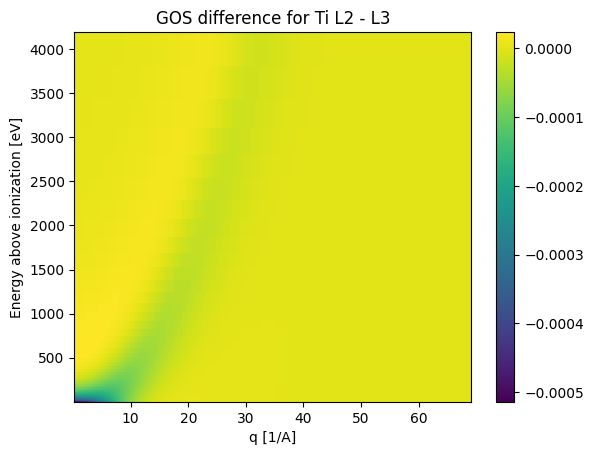

In [3]:
# Plot the GOS for the L2 and L3 edges and their difference
plot_gos(Ti_L2)
plot_gos(Ti_L3)

plt.pcolormesh( Ti_L2.q_axis/1e10,Ti_L2.free_energies, Ti_L2.gos - Ti_L3.gos)
plt.xlabel('q [1/A]')
plt.ylabel('Energy above ionization [eV]')
plt.colorbar()
plt.title('GOS difference for ' + element + ' L2 - L3')

# Step 1: Compute the double differential cross-sections from the GOS

The double differential scattering cross-section (DDSCS) can be written as:

$\frac{\partial^2 \sigma}{\partial E \partial \Omega} = (\frac{2\pi}{\hbar})^4 (\gamma m_e)^2 \sum_{i,f} \frac{k_f}{k_i} |\bra{f} V \ket{i}|^2 \delta(E_i-E_f+\Delta E)$

$ = \frac{4 \gamma^2}{a_0^2 q^4} \frac{k_f}{k_i} |S(q,E)|^2, $

$ = \frac{4 \gamma^2 }{q^2} \frac{R}{\Delta E} \frac{k_f}{k_i} f(q,E)$

where $\gamma$ is the Lorentz factor for relativistic scalar correction, $a_0$ is the Bohr radius, $R$ is the Rydberg energy, $k_i$ and $k_f$ are the wave number of the incoming and outgoing plane waves, respectively. 

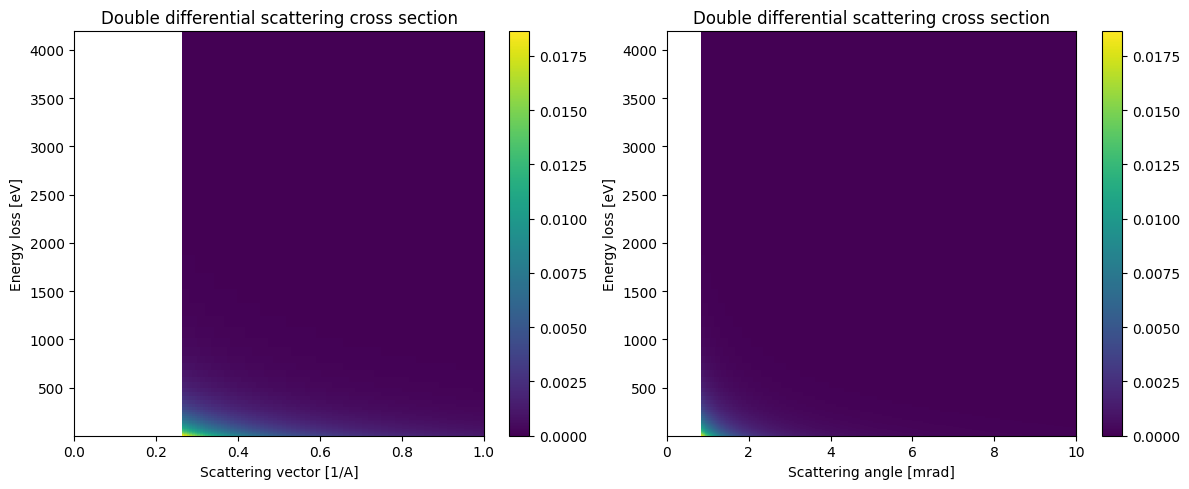

In [4]:
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edge import ZezhongCoreLossEdge
from pyEELSMODEL.core.spectrum import Spectrumshape
import pyEELSMODEL.misc.hs_gdos as hsdos
import numpy as np
import pyEELSMODEL.misc.physical_constants as pc
import matplotlib.pyplot as plt

specshape = Spectrumshape(dispersion=0.1,offset=280,size=3000)
A = 1
E0=300e3
alpha = 0
beta = 0.1
element = 'O'
edge = 'K' 
q_steps=100

edge = ZezhongCoreLossEdge(specshape=specshape, A=A, E0=E0, alpha=alpha, beta=beta, element=element, edge=edge, q_steps=q_steps,dir_path='data/')


def energy2wavelength(energy: float) -> float:
    """
    Calculate relativistic de Broglie wavelength from energy.

    Parameters
    ----------
    energy: float
        Energy [eV].

    Returns
    -------
    float
        Relativistic de Broglie wavelength [Å].
    """

    return (
        pc.h()
        * pc.c()
        / np.sqrt(energy * (2 * pc.m0() * pc.c()**2 / pc.e() + energy))
        / pc.e()
        * 1.0e10
    )

def ddscs_dE_dOmega(free_energies, ek, E0, q_axis, GOSmatrix):
    """scattering cross section as a function of energy loss and solid angle

    Args:
        free_energies: 1d numpy array
            The energy axis on which the GOS table is calculated without the onset
            energy [eV]
        ek: float
            The onset energy of the calculated edge [eV]
        E0: float
            The acceleration voltage of the incoming electrons [V]
        q_axis: 1d numpy array
            The momentum on which the GOS table are calculated. [kg m /s]?
        GOSmatrix: 2d numpy array
            The GOS

    Returns:
        np.array: scattering cross section as a function of energy loss and solid angle
    """
    R = pc.R()
    gamma = pc.gamma(E0)
    energy_losses = free_energies + ek
    k0 = 2 * np.pi / energy2wavelength(E0)

    scs_list = []
    for idx, epsilon in enumerate(free_energies):
        kn = 2 * np.pi / energy2wavelength(E0-energy_losses[idx])
        scs = (
            4
            * gamma ** 2
            / q_axis**2
            * kn
            / k0
            * GOSmatrix[idx]
            / energy_losses[idx]
            * R
        )
        scs_list.append(scs)
    scs_list = np.array(scs_list).squeeze()

    return scs_list

def plot_ddscs(edge):
    E0 = edge.parameters[1].getvalue()
    k0 = 2 * np.pi / energy2wavelength(E0)
    ddscs = ddscs_dE_dOmega(edge.free_energies, edge.onset_energy,E0,edge.q_axis/1e10, edge.gos)
    plt.subplots(1, 2, figsize=(12, 5))
    plt.subplot(121)
    plt.pcolormesh(edge.q_axis/1e10, edge.free_energies, ddscs)
    plt.ylabel('Energy loss [eV]')
    plt.xlabel('Scattering vector [1/A]')
    plt.xlim([0, 1])
    plt.colorbar()
    plt.tight_layout()
    plt.title('Double differential scattering cross section')
    plt.subplot(122)
    theta = np.arctan(edge.q_axis/1e10 /k0)*1e3 # this is approximation
    plt.pcolormesh(theta, edge.free_energies, ddscs) 
    plt.xlim([0, 10])
    plt.xlabel('Scattering angle [mrad]')
    plt.ylabel('Energy loss [eV]')
    plt.title('Double differential scattering cross section')
    plt.colorbar()  
    plt.tight_layout()

plot_ddscs(edge)

# Step 2: integrate the DDSCS with the EELS geometry

In this section, we will explain how to consider the experimental EELS geometry (i.e. EELS collection angle and STEM convergence angle) for cross-section calculations. One can integrate over the EELS collection angle to obtain the differential cross section as a function of energy loss. Instead of using the double differential cross in previous section, we use the differential cross section defined as:

$\frac{d\sigma}{dE} = \frac{4\pi\gamma^2}{k_i^2} \int^{Q_{\text{max}}}_{Q_{\text{min}}}\frac{|S(q,E)|^2}{Q} d(ln(Q)),$

where we take $Q=(a_0q)^2$ for ease of integration. From the scattering geometry, we can set the upper and lower limits of the integration as:
$q_{\text{min}} = k_i - k_f,$

$q_{\text{max}} = \sqrt{{k_i}^2 + {k_f}^2 - 2{k_i}{k_f}\cos(\beta_0)},$

as the minimum scattering angle is zero and the maximum scattering angle is bound by the EELS collection aperture $\beta_0$. The differential cross section as a function of energy loss is used to fit and quantify the experimental EELS spectra.

For plane wave illumination in TEM, the equation above is sufficient. For STEM convergent beam illumination, we need to take into account the finite angle of both the convergence angle and collection angle, which can be performed by the geometric correction procedure proposed by Kohl. The resulting correction factor is a cross-correlation function, which is written as [kohl1985](https://doi.org/10.1016/0304-3991(85)90081-6):

\begin{equation}
    \begin{aligned}
        & F_{\mathrm{BF}}\left(\alpha_0,\beta_0,\theta\right) \\
        & \quad=\left\{\begin{array}{l}
        \theta_{<}^2 / \alpha_0^2, \quad \text { for } 0 \leqslant \theta \leqslant\left|\alpha_0-\beta_0\right|, \\
        \pi^{-1}\left[\arccos (x)+\left(\beta_0^2 / \alpha_0^2\right) \arccos (y) \right. \\
        \left. -\left(1 / 2 \alpha_0^2\right) \sqrt{4 \alpha_0^2 \beta_0^2-\left(\alpha_0^2+\beta_0^2-\theta^2\right)^2}\right], \text { for }\left|\alpha_0-\beta_0\right|<\theta<\alpha_0+\beta_0, \\
        0, \text { otherwise. }
        \end{array}\right.
    \end{aligned}
\end{equation}

where 
\begin{equation}
    \begin{split}
    \theta_{<} & =\min \left(\alpha_0,\beta_0\right),\\
    x & =\frac{\alpha_0^2+\theta^2-\beta_0^2}{2 \alpha_0 \theta},\\
    y & =\frac{\beta_0^2+\theta^2-\alpha_0^2}{2 \beta_0 \theta}.
    \end{split}
\end{equation}
The EELS correction factor $F_{BF}$ (closely related to the contrast transfer function of bright field incoherent imaging) is used to correct the DDSCS for a given set of scattering angles in the STEM-EELS geometry. The effective partial scattering cross-section after integration in the momentum space is written as \cite{kohl1985simple}:
\begin{equation}
    \frac{d\sigma_{\text{eff}}}{dE} = \int_0^{\alpha_0+\beta_0}  F_{BF}(\alpha_0,\beta_0,\theta) \frac{d^2\sigma}{dEd\Omega} 2\pi\theta d\theta,
\end{equation}
or in terms of the Q space integral as in equation above

\begin{equation}
    \begin{split}
        \frac{d\sigma_{\text{eff}}}{dE} & = \frac{4\pi\gamma^2}{k_i^2} \int^{Q_{\text{max}}}_{Q_{\text{min}}}\frac{|S(q,E)|^2}{Q} F_{BF}(\alpha_0,\beta_0,\theta) d(ln(Q)),\\
        \text{ with } \theta & = \arccos\left(\frac{{k_i}^2+{k_f}^2-{q}^2}{2 {k_i} {k_f}}\right),\\
        q_{\text{min}} & = {k_i} - {k_f},\\
        q_{\text{max}} & = \sqrt{{k_i}^2 + {k_f}^2 - 2{k_i}{k_f}\cos(\alpha_0+\beta_0)},
    \end{split}
\end{equation}

This is implemented in the pyEELSModel so user can compute the theoretical spectrum for a given set of EELS parameters. For example,300 keV with convergence angle of 20 mrad and collection angle of 100 mrad

hll


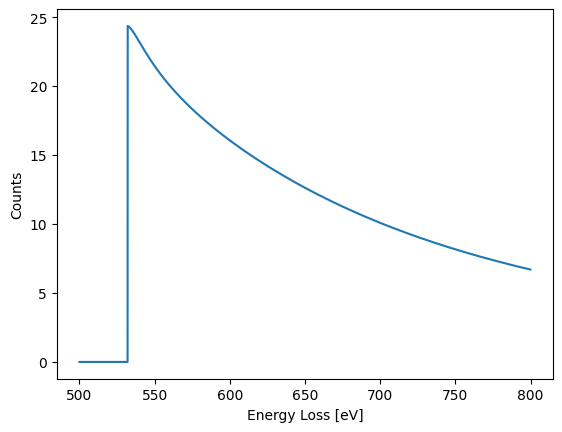

In [5]:
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edge import ZezhongCoreLossEdge
from pyEELSMODEL.core.spectrum import Spectrumshape
 
specshape = Spectrumshape(dispersion=0.1,offset=500,size=3000)
A = 1
E0=300e3
alpha = 0.02
beta = 0.1
element = 'O'
edge = 'K'
q_steps=100
 
edge = ZezhongCoreLossEdge(specshape=specshape, A=A, E0=E0, alpha=alpha, beta=beta, element=element, edge=edge, q_steps=q_steps,dir_path='data/')
scs = edge.calculate_cross_section()
import pyEELSMODEL.api as em
 
s =  em.Spectrum(specshape, data=scs)
s.plot()

We can also combine all the L edges (L1, L2 & L3) for Ti

hll
hll
hll
hll
hll
hll


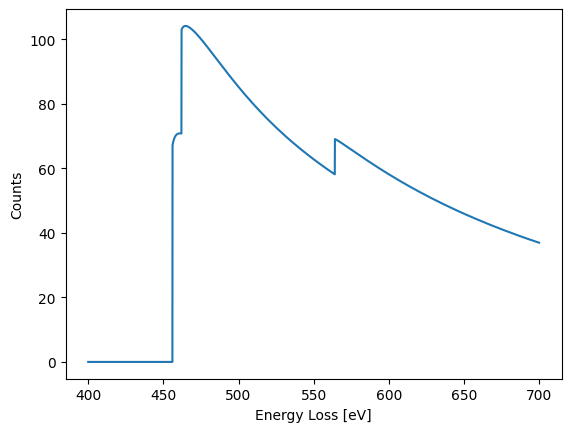

In [6]:
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edgecombined import ZezhongCoreLossEdgeCombined
from pyEELSMODEL.core.spectrum import Spectrumshape
 
specshape = Spectrumshape(dispersion=0.1,offset=400,size=3000)
A = 1
E0=300e3
alpha = 0.02
beta = 0.1
element = 'Ti'
edge = 'L'
q_steps=100
 
edge = ZezhongCoreLossEdgeCombined(specshape=specshape, A=A, E0=E0, alpha=alpha, beta=beta, element=element, edge=edge, q_steps=q_steps,dir_path='data/')
scs = edge.calculate_cross_section()
import pyEELSMODEL.api as em
 
s =  em.Spectrum(specshape, data=scs)
s.plot()

# Step 3: EELS quantification


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyEELSMODEL.api as em
from pyEELSMODEL.components.linear_background import LinearBG
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edgecombined import ZezhongCoreLossEdgeCombined
from pyEELSMODEL.components.gdoslin import GDOSLin
from pyEELSMODEL.components.MScatter.mscatterfft import MscatterFFT

# %matplotlib qt5

In [8]:
filename = os.path.join(os.getcwd(), 'data', 'hl.msa')
filenamell = os.path.join(os.getcwd(), 'data', 'll.msa')

In [9]:
#The experimental parameters 
alpha = 0.9e-3 #convergence angle [rad]
beta = 2.675e-3 #collection angle [rad]
E0 = 300e3 #acceleration voltage [V]

In [10]:
# The edges in the spectrum
elements = ['Ti', 'O']
edges = ['L', 'K']

## Loading the datasets

In [11]:
s0 = em.Spectrum.load(filename)
ll = em.Spectrum.load(filenamell)

this will change the size and contents of the current spectrum
this will change the size and contents of the current spectrum


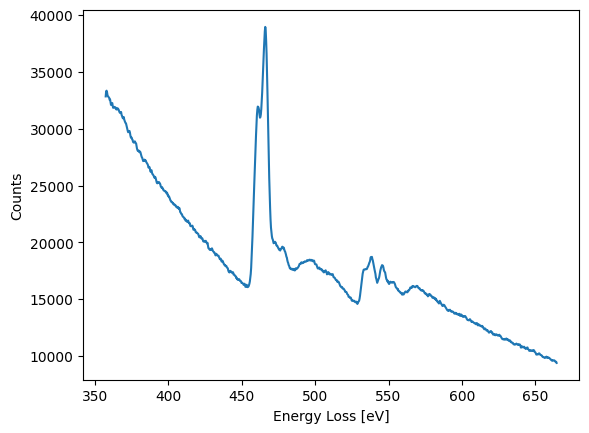

In [12]:
#the core loss spectrum
s0.plot()

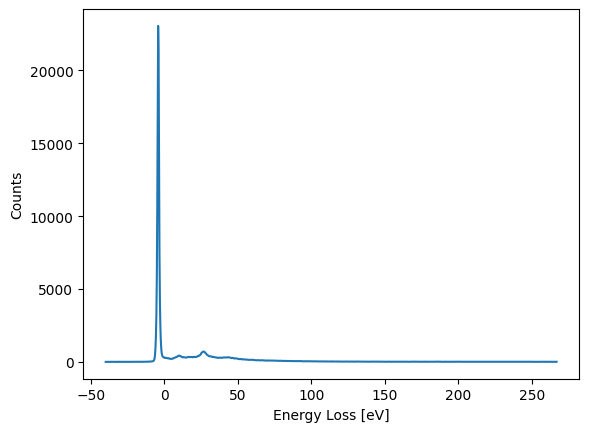

In [13]:
#the low loss spectrum
ll.plot()

Downloaded '/home/zzhang/OneDrive/code/pyEELSMODEL/pyEELSMODEL/../pyEELSMODEL/database/Zhang/Dirac_GOS.gosh' successfully.
hll


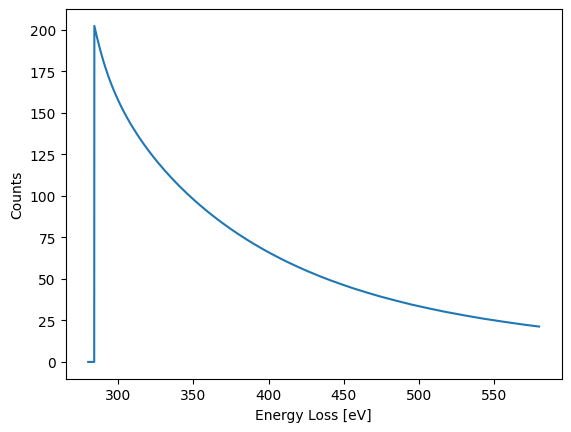

In [14]:
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edge import ZezhongCoreLossEdge
from pyEELSMODEL.core.spectrum import Spectrumshape

specshape = Spectrumshape(dispersion=0.1,offset=280,size=3000)
A = 1
E0=80e3
alpha = 0
beta = 0.1
element = 'C'
edge = 'K' 
q_steps=100

edge = ZezhongCoreLossEdge(specshape=specshape, A=A, E0=E0, alpha=alpha, beta=beta, element=element, edge=edge, q_steps=q_steps)
scs = edge.calculate_cross_section()
import pyEELSMODEL.api as em

s =  em.Spectrum(specshape, data=scs)
s.plot()

## Conventional power-law subtraction
It is shown how the conventional background subtraction will be performed on a single spectrum. A background window (*windows*) should be selected and integration range (*ranges*) should be chosen.

In [15]:
#A list of integration windows
windows = [[454,500],[530,590]]
#The signal ranges over which needs to be fitted
ranges = [(380,450),(512,527)]


hll
hll
hll
hll


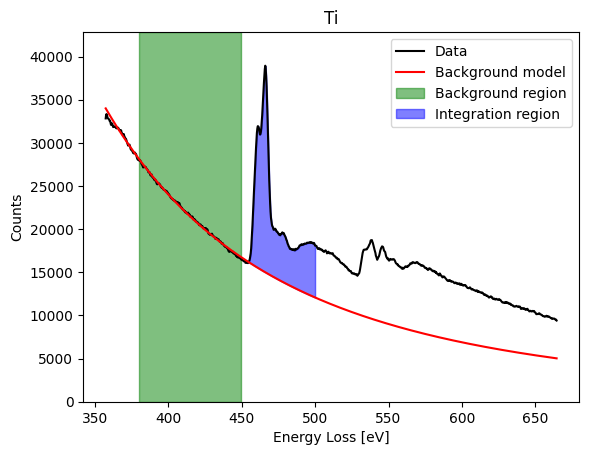

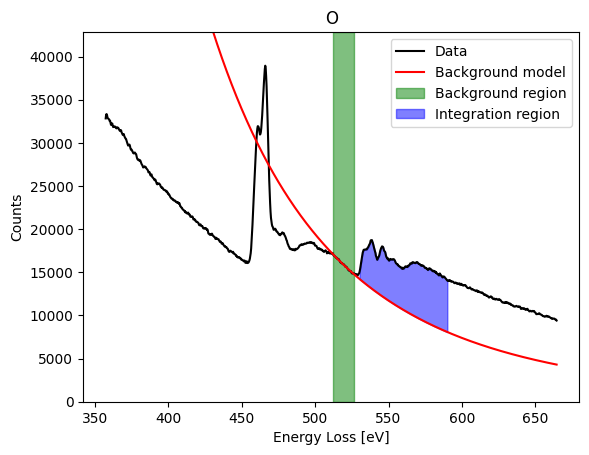

In [16]:
#The background fitting procedure
conv_abundance = np.zeros(len(windows)) #the integrated intensities will be saved in this array
for ii in range(len(windows)):
    back = em.BackgroundRemoval(s0, signal_range=ranges[ii]) #background removal object
    s0_rem = back.calculate() #calculates the background subtracted signal
    conv_abundance[ii] = back.quantify_from_edge(windows[ii], elements[ii], edges[ii], E0, alpha, beta, ll=ll)
    fig = back.show_fit_result(integration_range=windows[ii]) #small function which shows the fitted result
    fig.axes[0].set_title(elements[ii])


## Model based fitting
A model based fitting approach is used to quantify the core-loss spectrum. 

#### Model
The model  needs to be defined and consist out of four components.
1. Background: Linear background model
2. Titanium L edge
3. Oxygen K edge
4. Low-loss to take multiple scattering into account

In [17]:
#The background model, in this case it is linear
specshape = s0.get_spectrumshape()
BG = LinearBG(specshape, rlist=np.linspace(1,5,4))

In [18]:
#The components of the edges
#Rather slow due to cross section computation
comp_elements = []
for elem, edge in zip(elements, edges):
    comp = ZezhongCoreLossEdgeCombined(specshape, 1, E0, alpha, beta, elem, edge)
    comp_elements.append(comp)

hll
hll
hll
hll


In [19]:
#Add fine structure on the edges
comp_fine = []
for comp in comp_elements:
    comp_fine.append(GDOSLin.gdoslin_from_edge(specshape, comp, pre_e=5, ewidth=50, degree=30))
#pre_e: is how much energy before the edge onset, the linear interpolation can be performed
#ewidth: the width of the interpolation region
#degree: The number of points used in the interpolated region

In [20]:
#The low loss spectrum which is the convolutor
ll_comp = MscatterFFT(specshape, ll)

In [21]:
#the list containing all the components
component_list = [BG]+comp_elements+comp_fine+[ll_comp]


In [22]:
#Defining the model we are going to use to fit the spectrum
mod = em.Model(specshape, components=component_list) #The model object

### Fitter
A linear fitter is chosen since the model is enitirely linear. 

In [23]:
#Defining the fitter used which in this case is the linear fitter
fit = em.LinearFitter(s0, mod, method='ols') #The fitter object 

cannot use analytical gradients since a convolutor is inside model


In [24]:
#Performing the fit
fit.perform_fit()


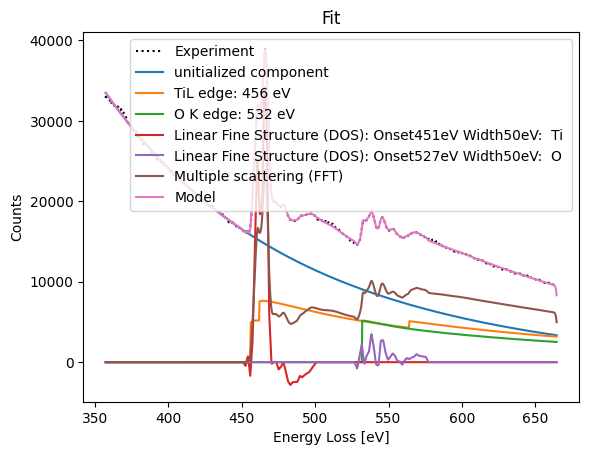

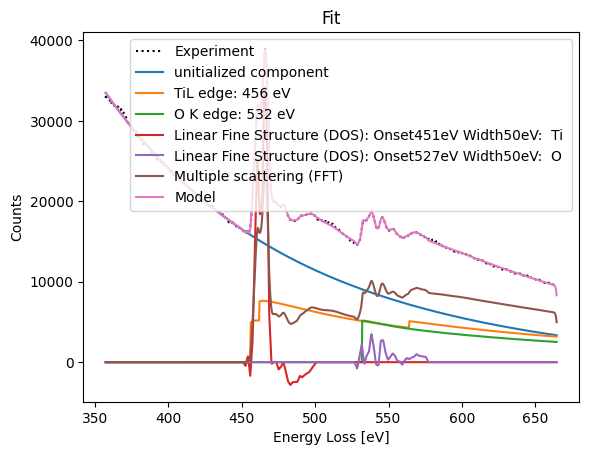

In [25]:
fit.plot()

# Quantification of Ti/O
Here it shown how to get the elemental quanticiations from the fitted spectra. It is seen how different methods already introduce different values for the quantification. Hence, be carefull with trying to estimate absolute elemental abundances with EELS. 

The value of each fitted parameter is accessed by the .getvalue() function. Note that the class should be a parameter. The parameter is most easily found by the components which are selected to make a model. A parameter can only store one value hence this is **not** the method to get results from a MultiSpectrum. 

In [26]:
conv_TiO = conv_abundance[0]/conv_abundance[1]
model_TiO = comp_elements[0].parameters[0].getvalue()/comp_elements[1].parameters[0].getvalue()


In [27]:
print('Titanium over oxygen ratio is expected to be 0.333')
print('Conventional Power-law: {}'.format(conv_TiO))
print('Model-based: {}'.format(model_TiO))

Titanium over oxygen ratio is expected to be 0.333
Conventional Power-law: 0.3481985287513489
Model-based: 0.3439156756262771
